In [3]:
from math import gamma

from networkx.algorithms.bipartite.basic import color
%matplotlib inline
import torch
import  numpy as np
from mpl_toolkits import mplot3d
import d2l

In [4]:
def f(X):
    return X * torch.cos(np.pi * X)

def g(X):
    """
    torch.cos(5 * np.pi * X)是一个高频的余弦函数，添加这一项可以惩罚模型中可能出现的高频变化
    在实际应用中，高频变化往往对应着训练模型对训练数据的过拟合，通过添加这一正则化项，可以让模型
    更加平滑，提高其泛化能力。
    系数 0.2 则控制了正则化项的权重。若这个数值过大，模型会过于平滑，可能导致欠拟合。
    """
    return f(X) + 0.2 * torch.cos(5 * np.pi * X)

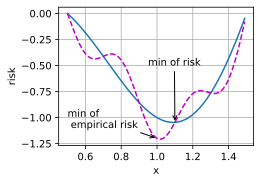

In [12]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle="->"))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate("min of\n empirical risk", (1.0, -1.2), (0.5, -1.1))
annotate("min of risk", (1.1, -1.05), (0.95, -0.5))

In [13]:
%matplotlib inline
import numpy as np
import torch
import d2l

In [14]:
def f(x): # 目标函数
    return x ** 2

def f_grad(x): # 目标函数的梯度
    return x * 2

epoch 10, x:7.295479


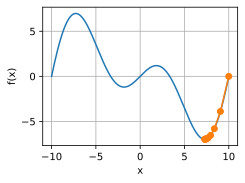

In [31]:
# 使用 x=0 作为初值，并假设 eta=0.2。使用梯度下降法迭代 x 共十次
def gd(eta, f_grad):
    x = 10.0
    result = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        result.append(float(x))
    print(f"epoch 10, x:{x:f}")
    return result

result = gd(0.2, f_grad)

# 绘制 x 的梯度下降图
def show_trace(result, f):
    n = max(abs(min(result)), abs(max(result)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, result], [[f(x) for x in f_line], [f(x) for x in result]],
             'x', 'f(x)', fmts=['-', '-o'])

show_trace(result, f)

epoch 10, x:8.284779


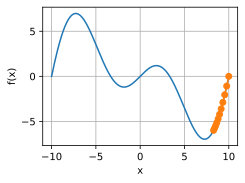

In [29]:
# 学习率较小的情况
show_trace(gd(0.05, f_grad), f)

epoch 10, x:61.917364


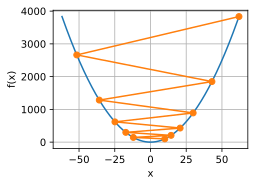

In [17]:
# 学习率较大反而可能导致发散或抖动
show_trace(gd(1.1, f_grad), f)

In [19]:
def train_2d(trainer, steps=20, f_grad=None):
    """
    用定制的训练机优化2D目标函数
    """
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f"epoch {i+1}, x1: {float(x1):f}, x2: {float(x2):f}")
    return results

def show_trace_2d(f, results):
    """
    显示优化过程中2D变量的轨迹
    """
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color="#ff7f0e")
    x1, x2 = torch.meshgrid(
        torch.arange(-5.5, 1.0, 0.1),
        torch.arange(-3.0, 1.0, 0.1),
        indexing='ij'
    )
    d2l.plt.contour(x1, x2, f(x1, x2), colors="#1f77b4")
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


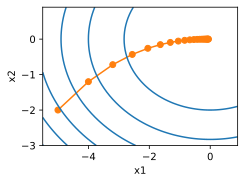

In [21]:
def f_2d(x1, x2): #目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2): # 目标函数的梯度
    return  (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad): # 更新函数
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 10, x: tensor(0.)


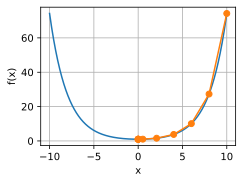

In [22]:
# 使用牛顿法进行梯度迭代
c = torch.tensor(0.5)

def f(x): # O目标函数
    return torch.cosh(c * x)

def f_grad(x): # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x): # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(26.8341)


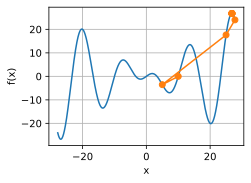

In [23]:
# 在牛顿法中，我们最终将除以 Hessian。这意味着如果二阶导数是负的，f值可能趋于增加
c = torch.tensor(0.15 * np.pi)

def f(x): # 目标函数
    return x * torch.cos(c * x)

def f_grad(x): # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x): # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(20.2219)


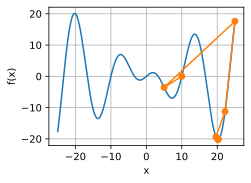

In [24]:
# 一种修正办法是取 Hessian 的绝对值
# 在牛顿法中，我们最终将除以 Hessian。这意味着如果二阶导数是负的，f值可能趋于增加
c = torch.tensor(0.15 * np.pi)

def f(x): # 目标函数
    return x * torch.cos(c * x)

def f_grad(x): # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x): # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / abs(f_hess(x))
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


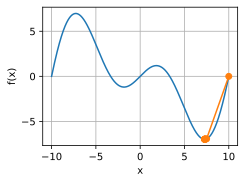

In [32]:
show_trace(newton(0.5), f)

epoch 50, x1: 0.318681, x2: 0.187765


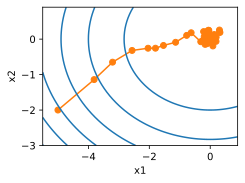

In [38]:
# 我们比较梯度下降(GD)和随机梯度下降(SGD)，方法是向梯度添加均值为0，方差为1的随机噪声
def f(x1, x2): # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2): # 目标函数的梯度
    return x1 * 2, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr() # lr() 是学习率函数
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

epoch 1000, x1: -0.785981, x2: -0.039780


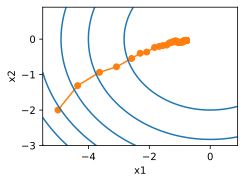

In [40]:
import math

def exponential_lr():
    # 在函数外部定义，而在函数内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

epoch 50, x1: 0.223332, x2: 0.006072


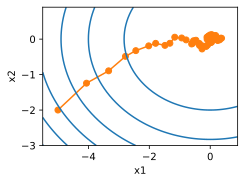

In [41]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

In [4]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
import d2l

d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                            '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                        dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                                batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [5]:
def sgd(params, states, hyperparams):
    """
    :param params:
    :param states: 状态输入
    :param hyperparams: 超参数字典，如学习率lr等

    由于我们在训练函数中对各个小批量样本的损失求平均，因此优化算法中的梯度不需要除以批量大小
    """
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [6]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                    requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                            (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

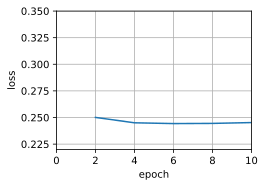

loss: 0.245, 0.008 sec/epoch


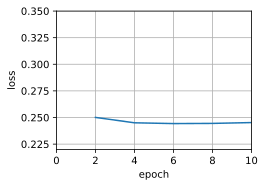

In [7]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
            sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

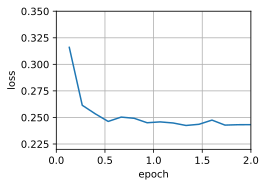

loss: 0.243, 0.012 sec/epoch


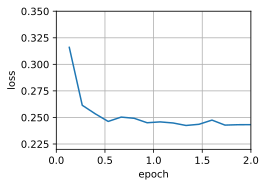

In [8]:
"""
当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，我们选择了很小的学习率。
"""
sgd_res = train_sgd(0.005, 1)

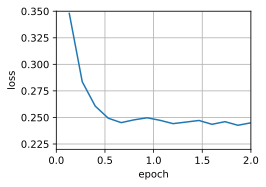

loss: 0.245, 0.001 sec/epoch


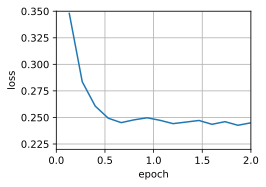

In [9]:
mini1_res = train_sgd(.4, 100)

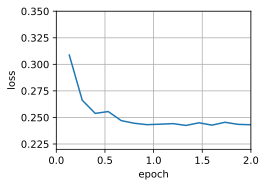

loss: 0.243, 0.002 sec/epoch


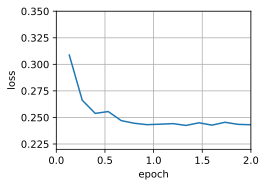

In [11]:
mini2_res = train_sgd(.05, 10)

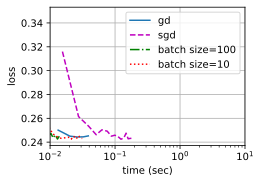

In [12]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
        'time (sec)', 'loss', xlim=[1e-2, 10],
        legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

In [15]:
# 使用深度学习框架自带算法实现一个通用训练函数
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5,1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss 计算平方误差时不带系数 1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f"loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch")

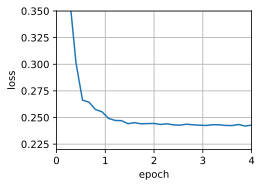

loss: 0.243, 0.003 sec/epoch


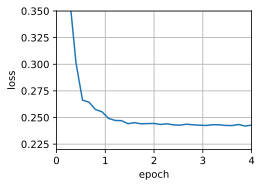

In [16]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

epoch 20, x1: -0.943467, x2: -0.000073


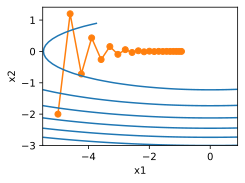

In [4]:
%matplotlib inline
import torch
import d2l


eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

In [5]:
"""
相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即 v。
它与梯度以及优化问题的变量具有相同的形状。
我们称这些变量为 states
"""
def init_momentum_states(feature_dim):
    v_w = torch.zeros(feature_dim, 1)
    v_b = torch.zeros(1)
    return v_w, v_b

In [6]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

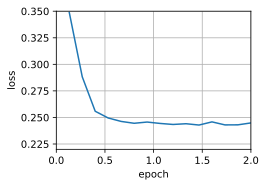

In [8]:
def train_momentum(lr, momentum, num_epoch=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr':lr, 'momentum':momentum}, data_iter,
                   feature_dim, num_epoch)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(lr=0.02, momentum=0.5)

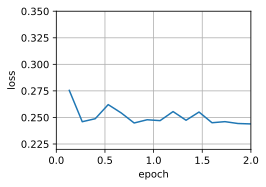

In [9]:
train_momentum(0.01, 0.9)

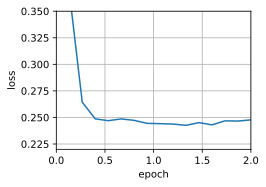

In [10]:
train_momentum(0.005, 0.9)

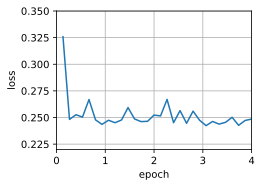

In [11]:
# 由于深度学习框架中的优化求解器早已构建了动量法，设置匹配参数会产生非常类似的轨迹
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

In [12]:
%matplotlib inline
import math
import torch
import d2l

epoch 20, x1: -2.382563, x2: -0.158591


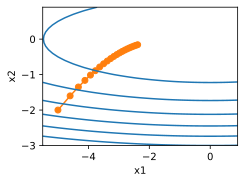

In [13]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta=0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

In [14]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros(feature_dim, 1)
    s_b = torch.zeros(1)
    return s_w, s_b

In [15]:
def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

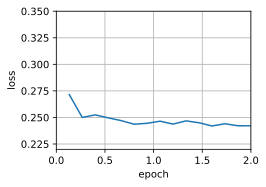

In [16]:
# 使用更大的学习率来训练模型
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
                {'lr': 0.1}, data_iter, feature_dim);

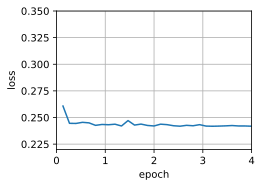

In [17]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

epoch 20, x1: -0.010599, x2: 0.000000


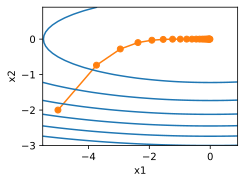

In [23]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1-gamma) * g1 ** 2
    s2 = gamma * s2 + (1-gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [24]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [31]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

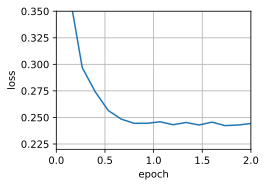

In [32]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
            {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

In [2]:
# Adadelta 需要为每个变量维护两个状态，即 s_t 和 \Delta x_t
%matplotlib inline
import torch
import d2l

def init_adadelta_states(feature_dim):
    s_w = torch.zeros(feature_dim, 1)
    s_b = torch.zeros(1)
    delta_w = torch.zeros(feature_dim, 1)
    delta_b = torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

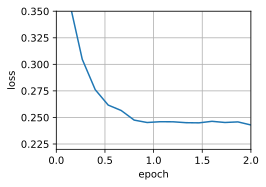

In [3]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
                {'rho': 0.9}, data_iter, feature_dim);

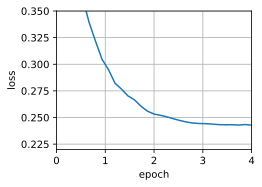

In [4]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

In [11]:
%matplotlib inline
import torch
import d2l

def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return (v_w, s_w), (v_b, s_b)

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
            + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

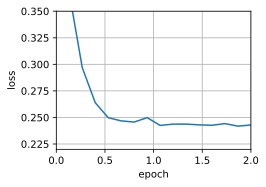

In [12]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
                {'lr': 0.01, 't': 1}, data_iter, feature_dim);

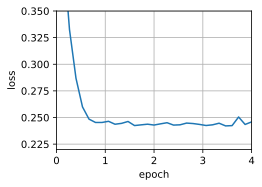

In [13]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

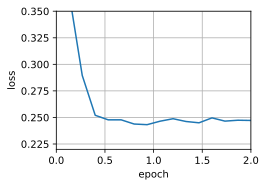

In [15]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s
            ) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
        hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
                {'lr': 0.01, 't': 1}, data_iter, feature_dim);

In [17]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
import d2l

"""
考虑应用ReLU激活函数、最大汇聚层的LeNet，用于Fashion-MNIST数据集的图片分类问题
"""
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
        scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                            (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f},'
            f'test acc {test_acc:.3f}')

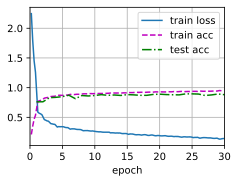

In [18]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [19]:
# 我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。例如，以动态的方式来响应优化的进展情况。
lr = 0.1
trainer.param_groups[0]['lr'] = lr
print(f"learning rate is now {trainer.param_groups[0]['lr']:.2f}")

learning rate is now 0.10


In [20]:
# 通常而言，我们应该定义一个调度器。当调用更新次数时，它将返回学习率的适当值。
# 简单定义学习率 eta = eta0 * (t + 1) ** (-0.5)
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * math.pow(num_update + 1.0, -0.5)

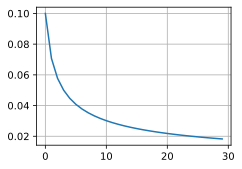

In [21]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

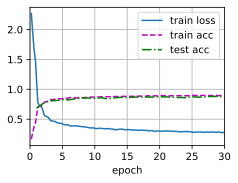

In [22]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
        scheduler)

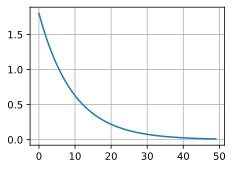

In [23]:
# 单因子调度器
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr


scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

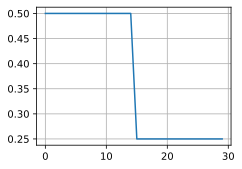

In [33]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
# 多因子调度器
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
        for t in range(num_epochs)])

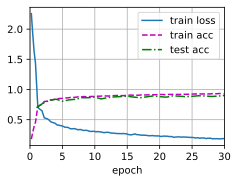

In [34]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
        scheduler)

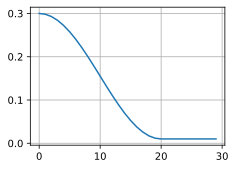

In [42]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
                warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps


    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
            * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase


    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
num_epochs = 30
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

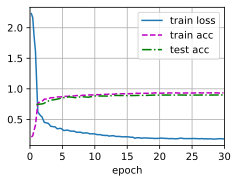

In [43]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
        scheduler)

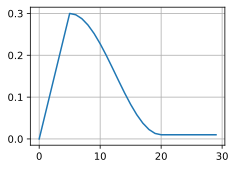

In [44]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

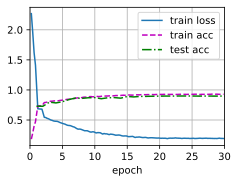

In [45]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
        scheduler)